# Simulation

## Data

The variables $X_1, X_2, X_3$ are sampled as follows.

- $X_1 \sim \mathcal{B}(1, 0.8)$
- $X_2 \sim \mathcal{B}(1, 0.4)$
- $X_3 \sim \mathcal{B}(1, 0.6)$

The dependent variable $y$ is sampled as follows.

- $z = 2.0 + 0.5 X_1 + 0.8 X_1 X_2 X_3$
- $p = \dfrac{1.0}{1.0 + \exp(-z)}$
- $y \sim \mathcal{B}(1, p)$

The design matrix $X$ is composed of the following variables and interactions.

- $X_1$
- $X_2$
- $X_3$
- $X_1 X_2$
- $X_1 X_3$
- $X_2 X_3$
- $X_1 X_2 X_3$

There are 1,000 sampled data points.

In [1]:
import numpy as np
import random
from scipy.stats import binom

random.seed(37)
np.random.seed(37)

N = 10_000

x1 = np.random.binomial(1, 0.8, N)
x2 = np.random.binomial(1, 0.4, N)
x3 = np.random.binomial(1, 0.6, N)
x1x2 = x1 * x2
x1x3 = x1 * x3
x2x3 = x2 * x3
x1x2x3 = x1 * x2 * x3

X = np.hstack((
    x1.reshape(-1, 1), 
    x2.reshape(-1, 1), 
    x3.reshape(-1, 1),
    x1x2.reshape(-1, 1),
    x1x3.reshape(-1, 1),
    x2x3.reshape(-1, 1),
    x1x2x3.reshape(-1, 1)
))

z = 2.0 + 0.5 * x1 + 0.8 * x1x2x3
p = 1.0 / (1.0 + np.exp(-z))
y = binom.rvs(1, p)

In [2]:
X.shape, y.shape

((10000, 7), (10000,))

## Descriptive statistics

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

df = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'x1x2': x1x2,
    'x1x3': x1x3,
    'x2x3': x2x3,
    'x1x2x3': x1x2x3,
    'y': y
})

df.describe()

,x1,x2,x3,x1x2,x1x3,x2x3,x1x2x3,y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.798400,0.394500,0.599900,0.316800,0.480200,0.236100,0.190300,0.926400
std,0.401215,0.488767,0.489943,0.465252,0.499633,0.424706,0.392557,0.261132
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


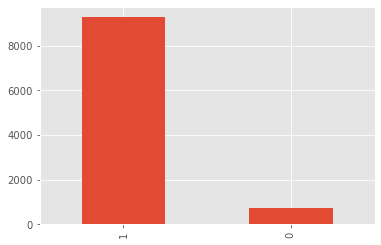

In [4]:
_ = df['y'].value_counts().plot(kind='bar')

## Balance the data

In [5]:
neg_df = df[df['y'] == 0]
pos_df = df[df['y'] == 1].sample(n=neg_df.shape[0], replace=False)

neg_df.shape, pos_df.shape

((736, 8), (736, 8))

In [6]:
df = pd.concat([neg_df, pos_df]).reset_index(drop=True)

In [7]:
df.describe()

,x1,x2,x3,x1x2,x1x3,x2x3,x1x2x3,y
count,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.00000
mean,0.752717,0.356658,0.593750,0.251359,0.449728,0.201087,0.144022,0.50000
std,0.431579,0.479175,0.491299,0.433942,0.497635,0.400949,0.351231,0.50017
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.50000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


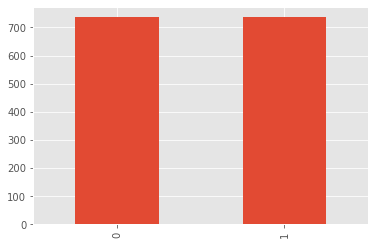

In [8]:
_ = df['y'].value_counts().plot(kind='bar')

In [9]:
X = df[[c for c in df.columns if c != 'y']].values
y = df['y'].values

X.shape, y.shape

((1472, 7), (1472,))

## Logistic regression

Logistic regression is applied to the data with the following regularization.

- none
- `L1` (Lasso)
- `L2` (Ridge) 
- ElasticNet

More [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) is available.

### None

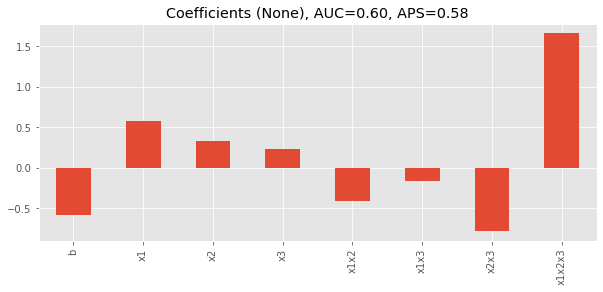

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

def get_model(reg='none'):
    if reg == 'l1':
        model = LogisticRegression(penalty='l1', solver='saga', C=0.5, random_state=37)
    elif reg == 'l2':
        model = LogisticRegression(penalty='l2', solver='saga', random_state=37)
    elif reg == 'elasticnet':
        model = LogisticRegression(penalty='elasticnet', l1_ratio=0.6, solver='saga', random_state=37)
    else:
        model = LogisticRegression(penalty='none', solver='saga', random_state=37, max_iter=10_000)
    
    return model

def get_coef(m):
    coefs = [m.intercept_[0]] + list(m.coef_[0])
    cols = ['b', 'x1', 'x2', 'x3', 'x1x2', 'x1x3', 'x2x3', 'x1x2x3']
    return pd.Series(coefs, index=cols)

def plot_model(m, X, y, reg):
    y_pred = m.predict_proba(X)[:,1]
    auc = roc_auc_score(y, y_pred)
    aps = average_precision_score(y, y_pred)
    _ = get_coef(model).plot(kind='bar', figsize=(10, 4), title=fr'Coefficients ({reg}), AUC={auc:.2f}, APS={aps:.2f}')

model = get_model('none')
model.fit(X, y)

plot_model(model, X, y, 'None')

In [11]:
import scipy.stats


def get_color(s, n=10):
    if s.loc['alpha=0.1']:
        return ['background-color: rgb(255, 0, 0, 0.18)'] * n
    else:
        return [None] * n
    
def do_lreg(df, reg='none'):
    sample = df.sample(df.shape[0], replace=True)
    X_tr = sample[[c for c in sample.columns if c != 'y']]
    y_tr = sample.y

    lr = LogisticRegression(penalty='l2', solver='liblinear')
    lr.fit(X_tr, y_tr)

    params = [lr.intercept_[0]] +  list(lr.coef_[0])

    return params

def get_se(X, y, reg='none', index=['b', 'x1', 'x2', 'x3', 'x1x2', 'x1x3', 'x2x3', 'x1x2x3']):
    lr = get_model(reg=reg)
    lr.fit(X, y)

    df = pd.DataFrame(X)
    df['y'] = y

    r_df = pd.DataFrame([do_lreg(df, reg=reg) for _ in range(100)])

    w = [lr.intercept_[0]] + list(lr.coef_[0])
    se = r_df.std()

    dof = X.shape[0] - X.shape[1] - 1

    summary = pd.DataFrame({
        'w': w,
        'se': se,
        'z': w / se,
        '.025': w - se,
        '.975': w + se,
        'df': [dof for _ in range(len(w))]
    })

    summary['P>|z|'] = scipy.stats.t.sf(abs(summary.z), df=summary.df)
    summary['alpha=0.1'] = summary['P>|z|'].apply(lambda p: p <= 0.1)
    summary['alpha=0.05'] = summary['P>|z|'].apply(lambda p: p <= 0.05)
    summary['alpha=0.01'] = summary['P>|z|'].apply(lambda p: p <= 0.01)
    summary.index = index

    return summary.style.apply(get_color, axis=1)

get_se(X, y, reg='none')

,w,se,z,.025,.975,df,P>|z|,alpha=0.1,alpha=0.05,alpha=0.01
b,-0.583817,0.156882,-3.721365,-0.740699,-0.426935,1464,0.000103,True,True,True
x1,0.569915,0.167271,3.407127,0.402643,0.737186,1464,0.000337,True,True,True
x2,0.328850,0.210137,1.564934,0.118713,0.538987,1464,0.058907,True,False,False
x3,0.236573,0.214230,1.104293,0.022343,0.450802,1464,0.134824,False,False,False
x1x2,-0.416265,0.263945,-1.577088,-0.680210,-0.152320,1464,0.057496,True,False,False
x1x3,-0.169315,0.222511,-0.760929,-0.391826,0.053196,1464,0.223411,False,False,False
x2x3,-0.783907,0.310143,-2.527568,-1.094050,-0.473764,1464,0.005795,True,True,True
x1x2x3,1.656283,0.339483,4.878836,1.316800,1.995766,1464,0.000001,True,True,True


### Lasso

For Lasso, we set `C=0.5` (smaller values of C means stronger regularization). 

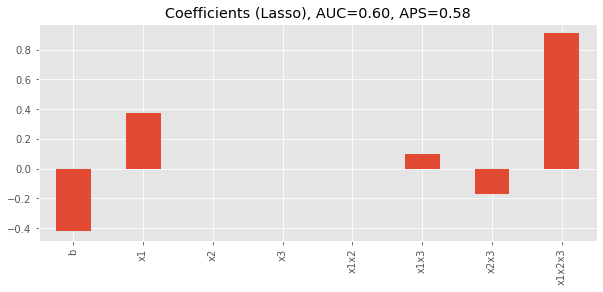

In [12]:
model = get_model('l1')
model.fit(X, y)

plot_model(model, X, y, 'Lasso')

In [13]:
get_se(X, y, reg='l1')

,w,se,z,.025,.975,df,P>|z|,alpha=0.1,alpha=0.05,alpha=0.01
b,-0.420358,0.166721,-2.521326,-0.587079,-0.253637,1464,0.005898,True,True,True
x1,0.375508,0.200176,1.875885,0.175331,0.575684,1464,0.030435,True,True,False
x2,0.000000,0.251915,0.000000,-0.251915,0.251915,1464,0.500000,False,False,False
x3,0.000000,0.209894,0.000000,-0.209894,0.209894,1464,0.500000,False,False,False
x1x2,0.000000,0.289023,0.000000,-0.289023,0.289023,1464,0.500000,False,False,False
x1x3,0.098222,0.236102,0.416015,-0.137880,0.334323,1464,0.338730,False,False,False
x2x3,-0.167419,0.291617,-0.574107,-0.459036,0.124198,1464,0.282992,False,False,False
x1x2x3,0.908034,0.295729,3.070498,0.612306,1.203763,1464,0.001088,True,True,True


## Ridge

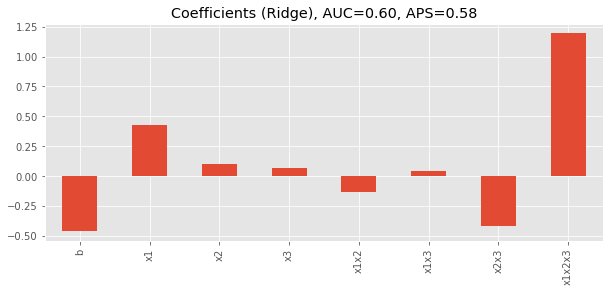

In [14]:
model = get_model('l2')
model.fit(X, y)

plot_model(model, X, y, 'Ridge')

In [15]:
get_se(X, y, reg='l2')

,w,se,z,.025,.975,df,P>|z|,alpha=0.1,alpha=0.05,alpha=0.01
b,-0.462740,0.175730,-2.633252,-0.638470,-0.287011,1464,0.004273,True,True,True
x1,0.425048,0.204961,2.073805,0.220088,0.630009,1464,0.019136,True,True,False
x2,0.101487,0.216946,0.467796,-0.115460,0.318433,1464,0.320000,False,False,False
x3,0.062668,0.207855,0.301500,-0.145187,0.270523,1464,0.381538,False,False,False
x1x2,-0.131538,0.239866,-0.548383,-0.371404,0.108328,1464,0.291756,False,False,False
x1x3,0.038639,0.237860,0.162446,-0.199221,0.276499,1464,0.435488,False,False,False
x2x3,-0.415528,0.281250,-1.477431,-0.696778,-0.134278,1464,0.069888,True,False,False
x1x2x3,1.193718,0.303616,3.931668,0.890102,1.497334,1464,0.000044,True,True,True


### Elasticnet

Take note of the `l1_ratio`; a value closer to 0 favors Ridge and a value closer to 1 favors Lasso.

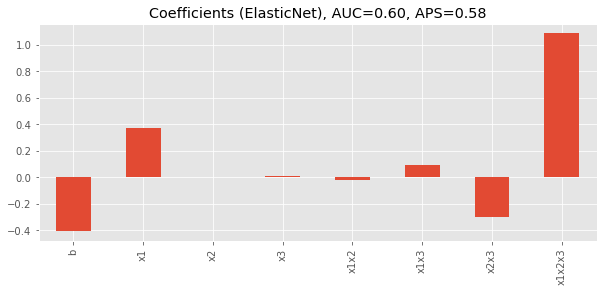

In [16]:
model = get_model('elasticnet')
model.fit(X, y)

plot_model(model, X, y, 'ElasticNet')

In [17]:
get_se(X, y, reg='elasticnet')

,w,se,z,.025,.975,df,P>|z|,alpha=0.1,alpha=0.05,alpha=0.01
b,-0.407891,0.184328,-2.212850,-0.592219,-0.223562,1464,0.013531,True,True,False
x1,0.369559,0.195380,1.891485,0.174178,0.564939,1464,0.029378,True,True,False
x2,0.000000,0.235972,0.000000,-0.235972,0.235972,1464,0.500000,False,False,False
x3,0.004957,0.210079,0.023597,-0.205122,0.215036,1464,0.490589,False,False,False
x1x2,-0.021526,0.277795,-0.077490,-0.299322,0.256269,1464,0.469122,False,False,False
x1x3,0.090115,0.246376,0.365763,-0.156261,0.336491,1464,0.357297,False,False,False
x2x3,-0.303343,0.272041,-1.115065,-0.575384,-0.031302,1464,0.132503,False,False,False
x1x2x3,1.083433,0.318361,3.403159,0.765072,1.401793,1464,0.000342,True,True,True
